In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-5.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-4.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-1.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-2.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-3.csv


In [2]:
import warnings
from glob import glob
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

In [3]:
# Write a wrangle function

def wrangle(filepath):
    # Read csv files into DataFrame
    df=pd.read_csv(filepath)
    
    # Subset to properties where price usd <4000_000
    mask_ba=df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt=df["property_type"]=="apartment"
    mask_price=df["price_aprox_usd"] < 4000_000
    df=df[mask_ba & mask_apt & mask_price]
    
    # Remove outliers by "surface_covered_in_m2"
    low, high=df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area=df["surface_covered_in_m2"].between(low, high)
    df=df[mask_area]
    
    # Drop columns 'Unnamed: 0'
    df.drop(columns=["Unnamed: 0"], inplace=True)
    
    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Extract neighborhood
    df["neighborhood"]=df["place_with_parent_names"].str.split("|",  expand=True)[1]
    df.drop(columns=["place_with_parent_names"], inplace=True)
    
    # Drop features with high null count
    df.drop(columns=["floor", "rooms","surface_total_in_m2", "expenses", "price_usd_per_m2"], inplace=True)
    
    # Drop low- and high-cardinality categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # drop leaky columns
    df.drop(columns=[
        'price',
        'price_aprox_local_currency',
        'price_per_m2'
    ], inplace = True)

    return df

In [4]:
# Use glob to create a list

files = glob("/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-*.csv")
files

['/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-5.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-4.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-1.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-2.csv',
 '/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-3.csv']

In [5]:
# Use wrangle function in a list comprehension to create a list 

frames = [wrangle(file) for file in files]

In [6]:
# concat

df = pd.concat([wrangle(file) for file in files], ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10517 entries, 0 to 10516
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        10517 non-null  float64
 1   surface_covered_in_m2  10517 non-null  float64
 2   lat                    9683 non-null   float64
 3   lon                    9683 non-null   float64
 4   neighborhood           10517 non-null  object 
dtypes: float64(4), object(1)
memory usage: 410.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,82737.39,75.0,19.362690,-99.150565,Benito Juárez
1,142253.50,92.0,19.399120,-99.141464,Benito Juárez
2,72197.60,62.0,19.291345,-99.124312,Tlalpan
3,44277.72,85.0,19.354987,-99.061709,Iztapalapa
4,193497.15,56.0,19.393650,-99.147690,Benito Juárez


## Explore

<AxesSubplot:>

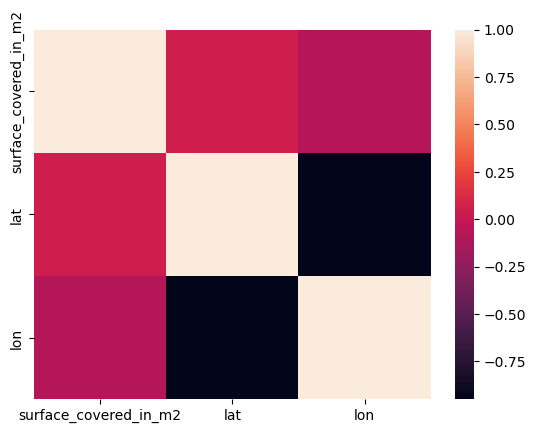

In [7]:
corr=df.select_dtypes("number").drop(columns = "price_aprox_usd").corr()
sns.heatmap(corr)

## Split

In [8]:
target = "price_aprox_usd"
features = df[["surface_covered_in_m2","lat","lon","neighborhood"]]
X_train = features
y_train = df[target]

In [9]:
# Calculate the baseline mean absolute error

y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 139840.25
Baseline MAE: 97097.63744007467


In [10]:
# instantiate
ohe = OneHotEncoder(use_cat_names=True)
# fit
ohe.fit(X_train)
# Transform
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(10517, 18)


,surface_covered_in_m2,lat,lon,neighborhood_Benito Juárez,neighborhood_Tlalpan,neighborhood_Iztapalapa,neighborhood_Gustavo A. Madero,neighborhood_Venustiano Carranza,neighborhood_Cuauhtémoc,neighborhood_Álvaro Obregón,neighborhood_Iztacalco,neighborhood_Coyoacán,neighborhood_Miguel Hidalgo,neighborhood_Cuajimalpa de Morelos,neighborhood_Azcapotzalco,neighborhood_Tláhuac,neighborhood_La Magdalena Contreras,neighborhood_Xochimilco
0,75.0,19.362690,-99.150565,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,92.0,19.399120,-99.141464,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,62.0,19.291345,-99.124312,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,85.0,19.354987,-99.061709,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,56.0,19.393650,-99.147690,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

In [12]:
# Calculate the training mean absolute error for predictions
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 65391.617398758026


## Communicate Results

In [13]:
# Create a function make_prediction
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_coverd_in_m2":area,
        "lat":lat,
        "lon":lon,
        "neighborhood":neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [14]:
# Test a function
make_prediction(301, -34.60, -58.46, "Benito Juárez")

'Predicted apartment price: $66445.82'

In [15]:
# Creating and interactive dashboard,created one using Jupyter Widgets
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=86, description='area', max=220, min=50), FloatSlider(value=19.494954619…